In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas


import tensorflow as tf
import tf_data

In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [6]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

metadata =  [  "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
            "nclusters_insc","max_en_cluster_insc","max_deta_cluster_insc",
            "max_dphi_cluster_insc", "max_en_cluster","max_deta_cluster","max_dphi_cluster",
            "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ]

In [7]:
_load_n_items = 10
_batch_size = 6
_nepochs = 1
_ntrain = 10000
_nval = 1000

In [17]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features,metadata, _batch_size)
# the indexes for energy and et are from the features list we requestes
total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds) 

In [18]:
X,y = tf_data.get(total_ds)

In [21]:
y_class, y_metadata = y

In [22]:
cl_X,cl_hits, is_seed,n_cl = X

# Graph building layer

In [67]:
from model import *
from plotting import * 

In [68]:
graph = GraphBuilding(output_dim_nodes=32)

In [54]:
rcn = RechitsGCN(nconv=3, input_dim = 4 , output_dim =12)

In [55]:
rechits = cl_hits.to_tensor()
mask_rechits, mask_cls = create_padding_masks(rechits)

In [56]:
output, (sa_output,convout, attention_weights, adj) = rcn(rechits, mask_rechits)

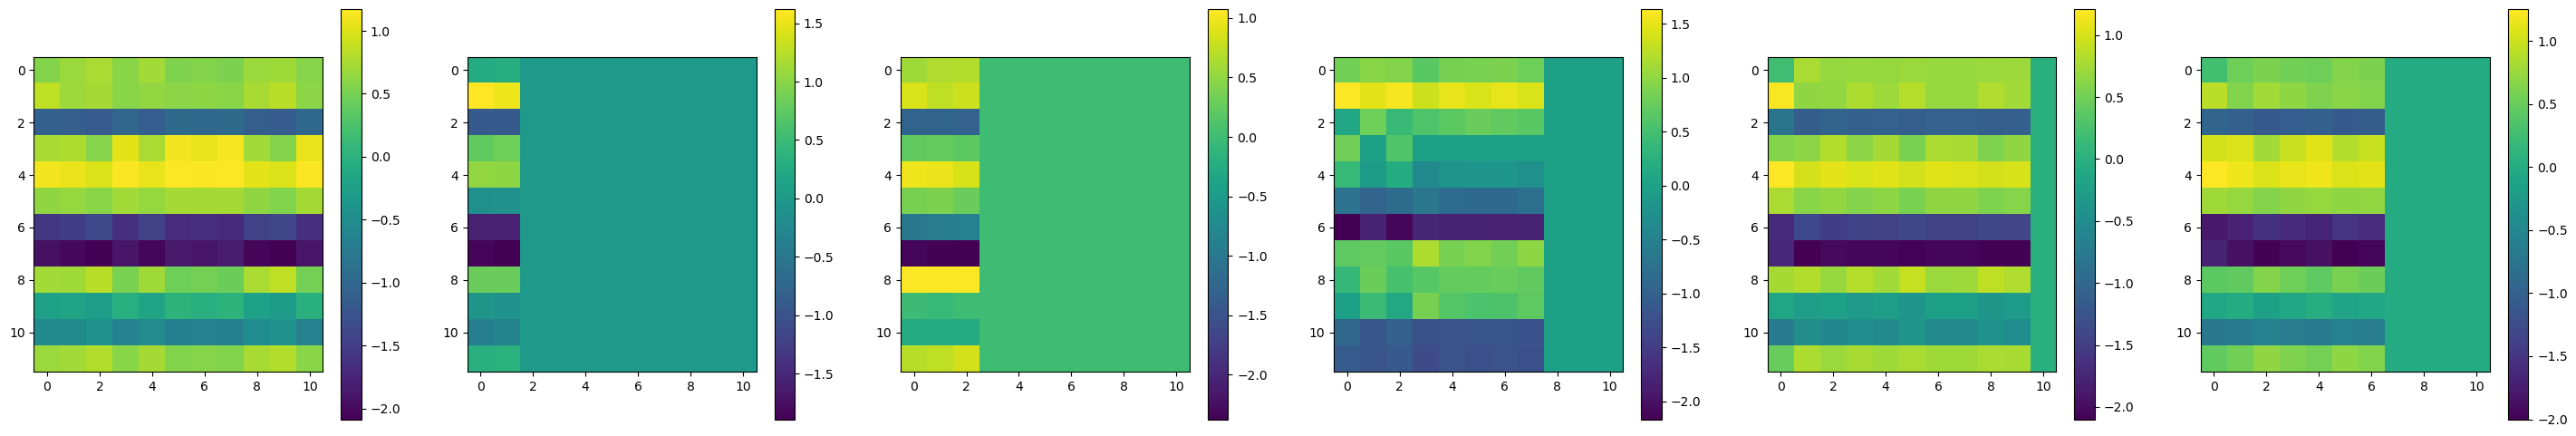

In [58]:
plotM(*output)

In [70]:
cl_x, coord, adj, mask, output_rechits, coord_att_ws = graph(X[0],X[1])

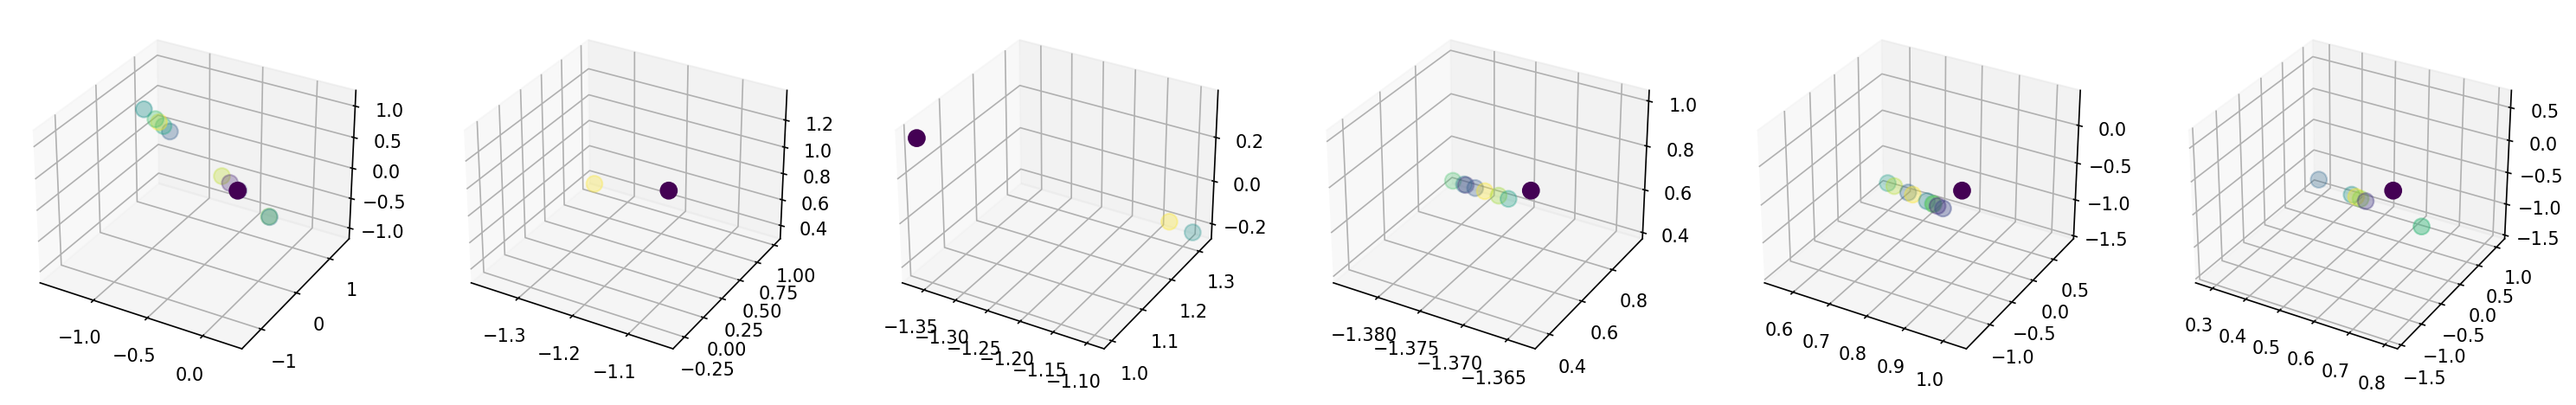

In [71]:
plot3D(coord, mask)

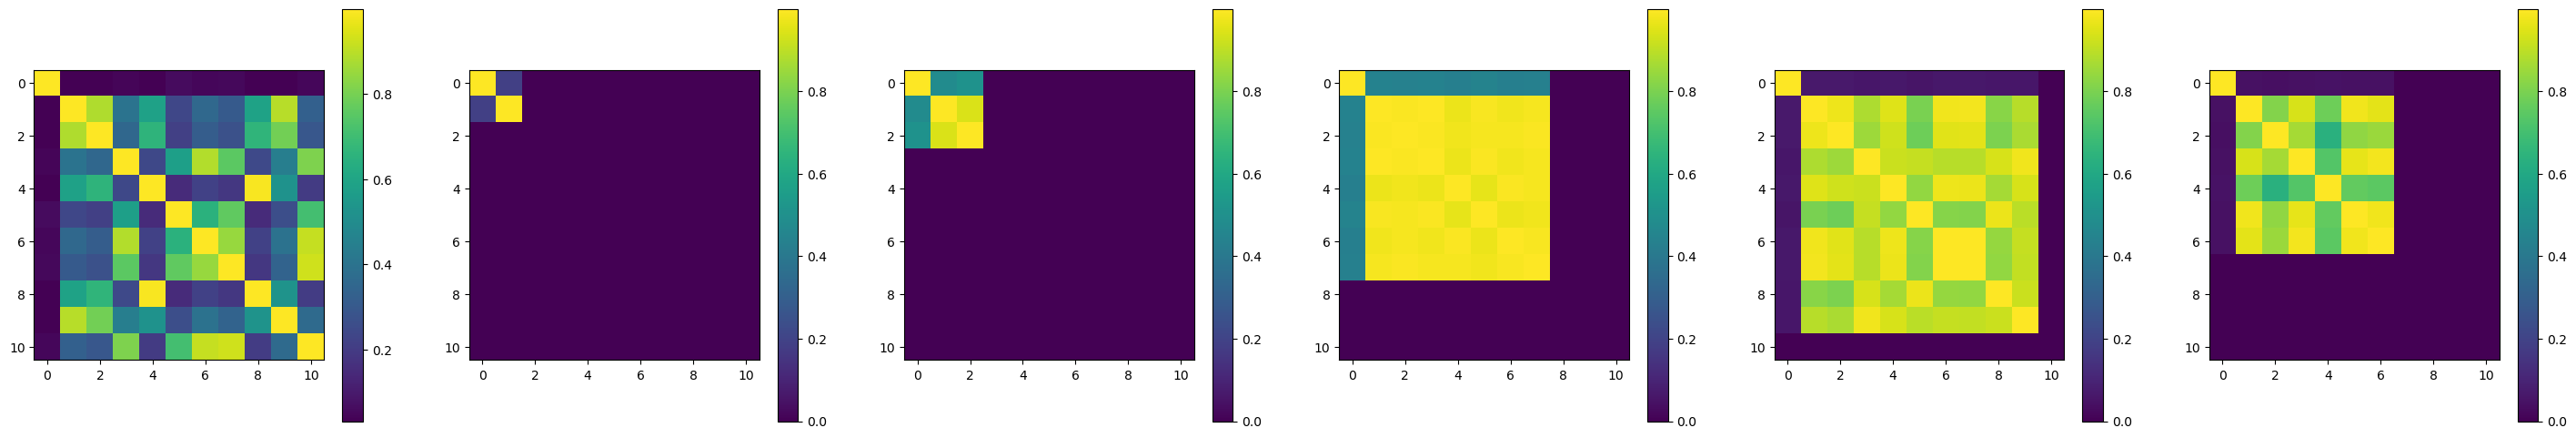

In [72]:
plotM(*adj)

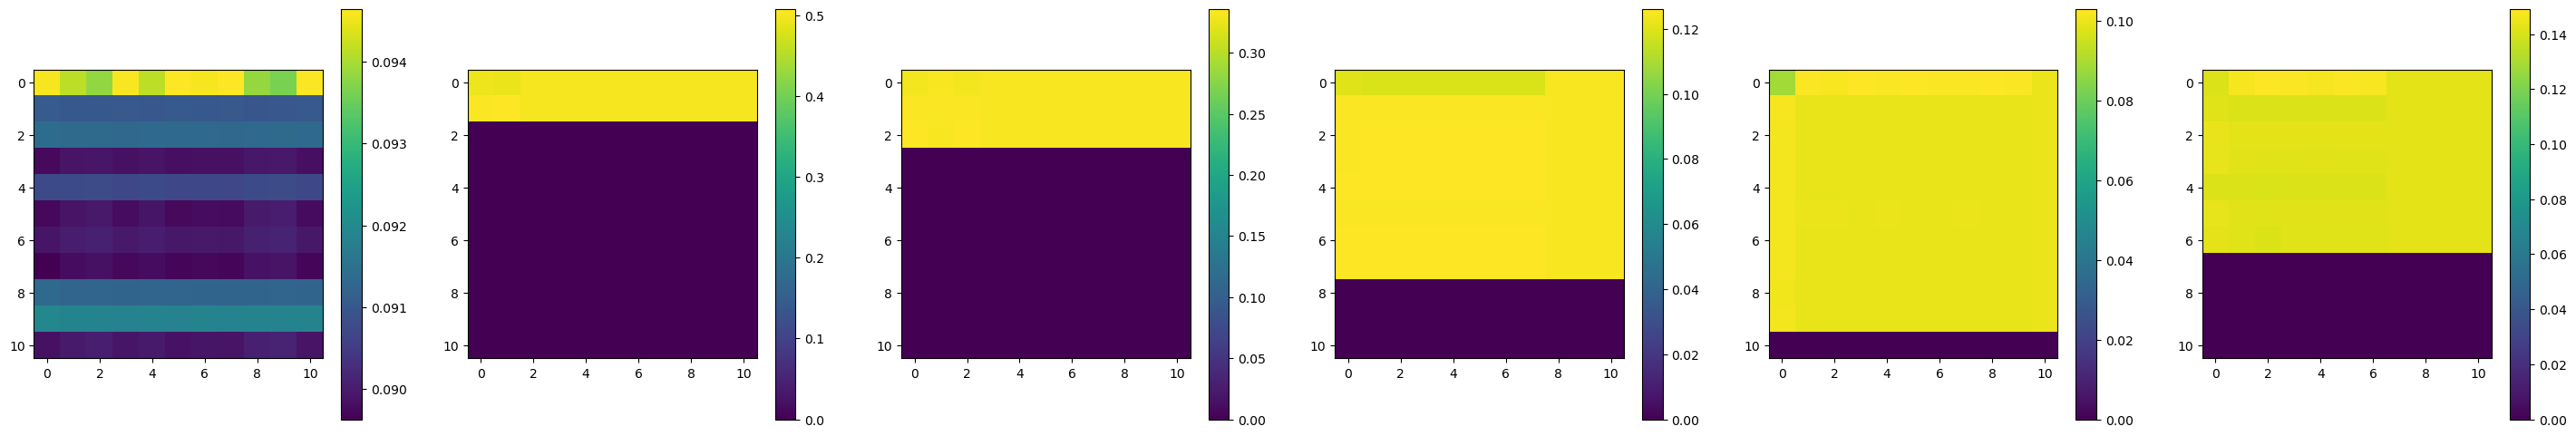

In [75]:
plotM(*coord_att_ws)

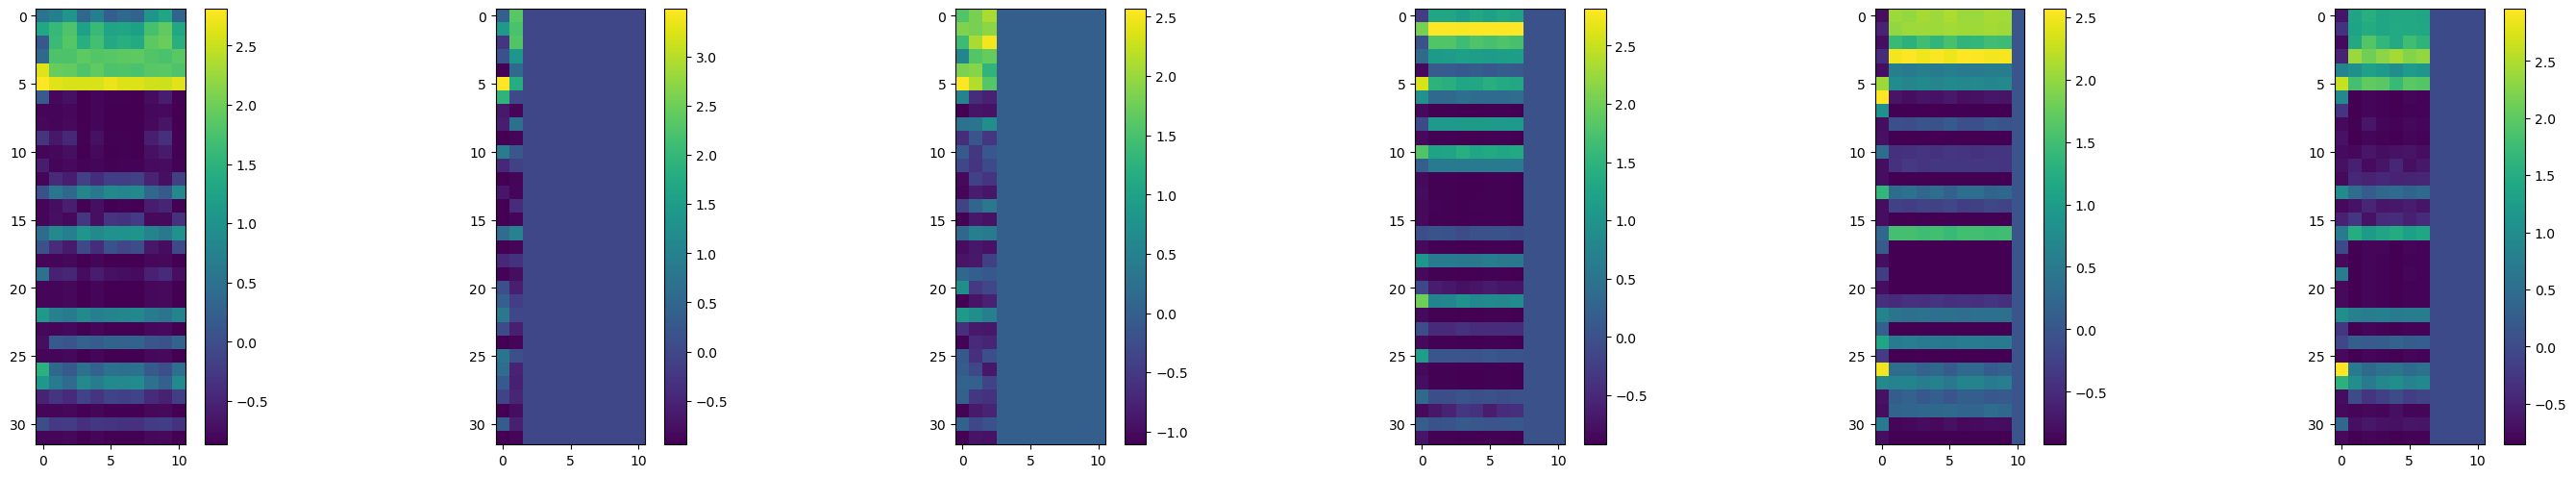

In [93]:
plotM(*cl_x)

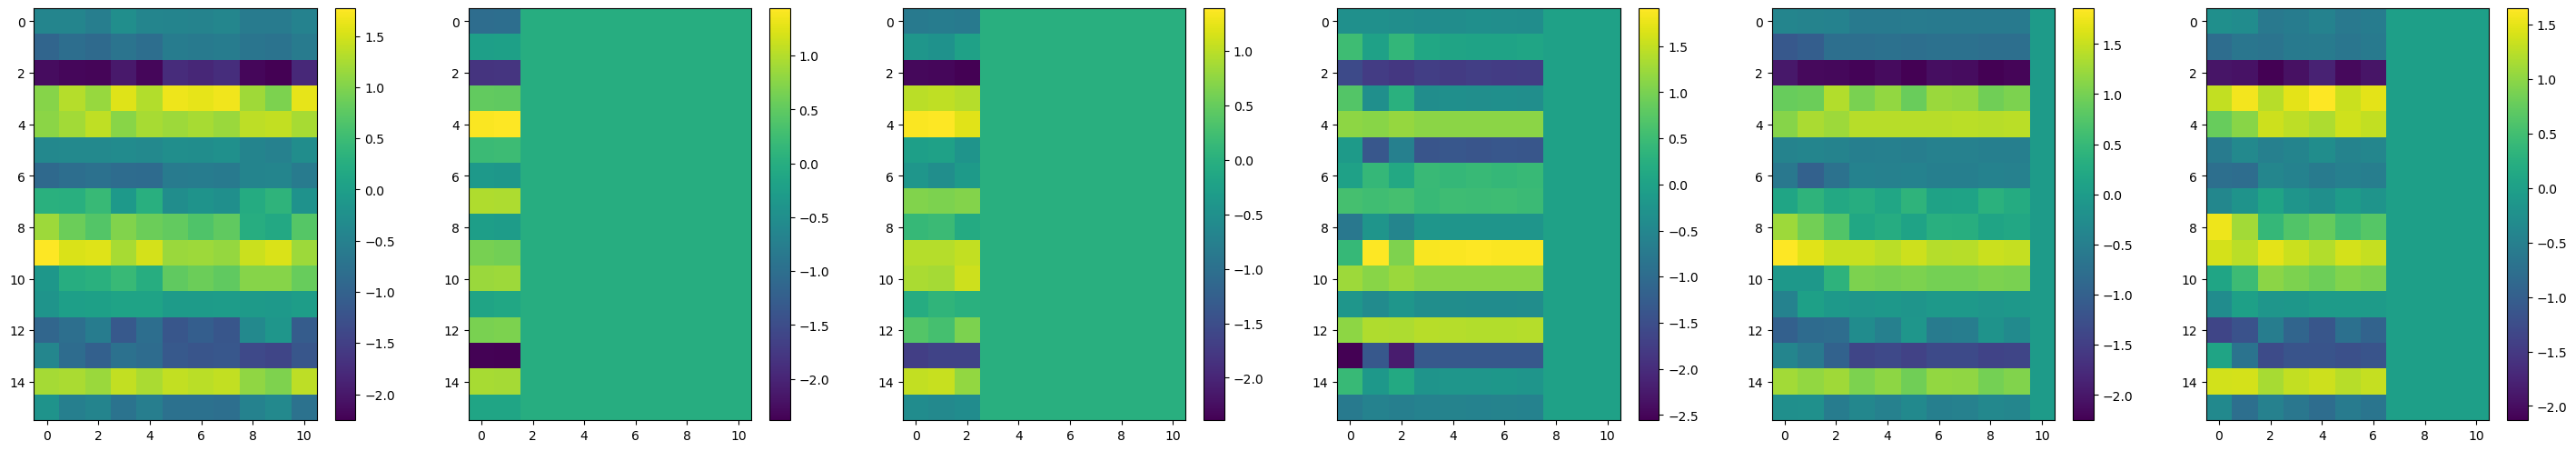

In [74]:
plotM(*output_rechits)

# Complete model

In [80]:
from model import *
from plotting import * 

In [81]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=32, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [27]:
a = model(X)

In [87]:
X, y = tf_data.get(ds_train)

In [41]:
X,y = tf_data.get(ds_test)

In [75]:
X,y = tf_data.get(special_ds)

In [76]:
dense_clclass, windclass, mask_cls, (cl_X, coord, adj, coord_att_ws, output_rechits, out_gcn, out_SAcl ,out_SAw, att_weights_clcall, att_w_windclass) = model(X)

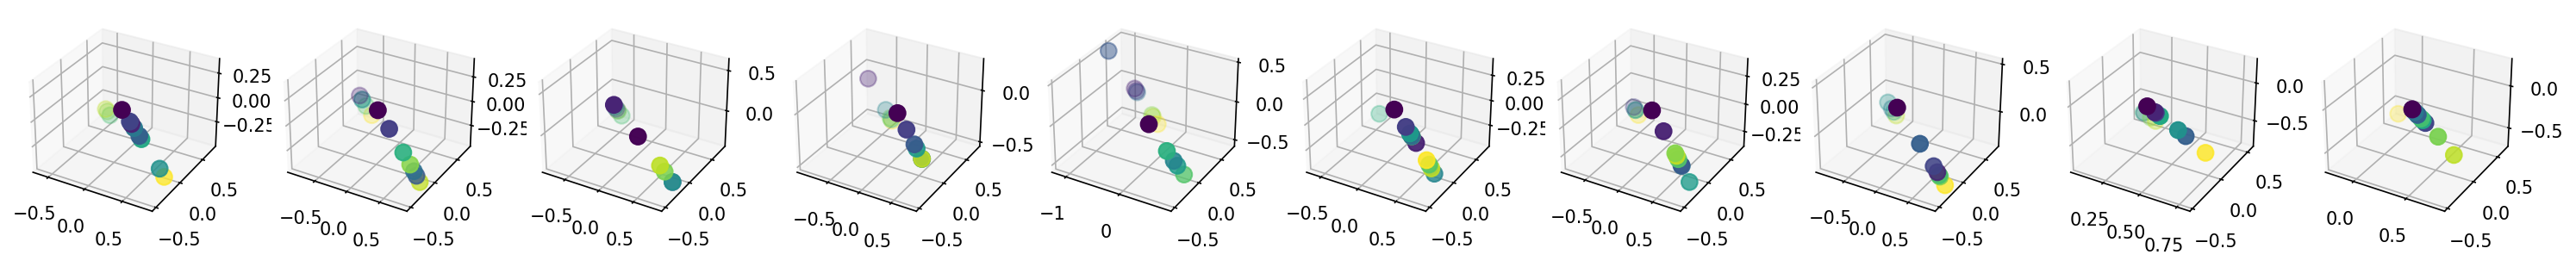

In [77]:
plot3D(coord[0:10], mask_cls)

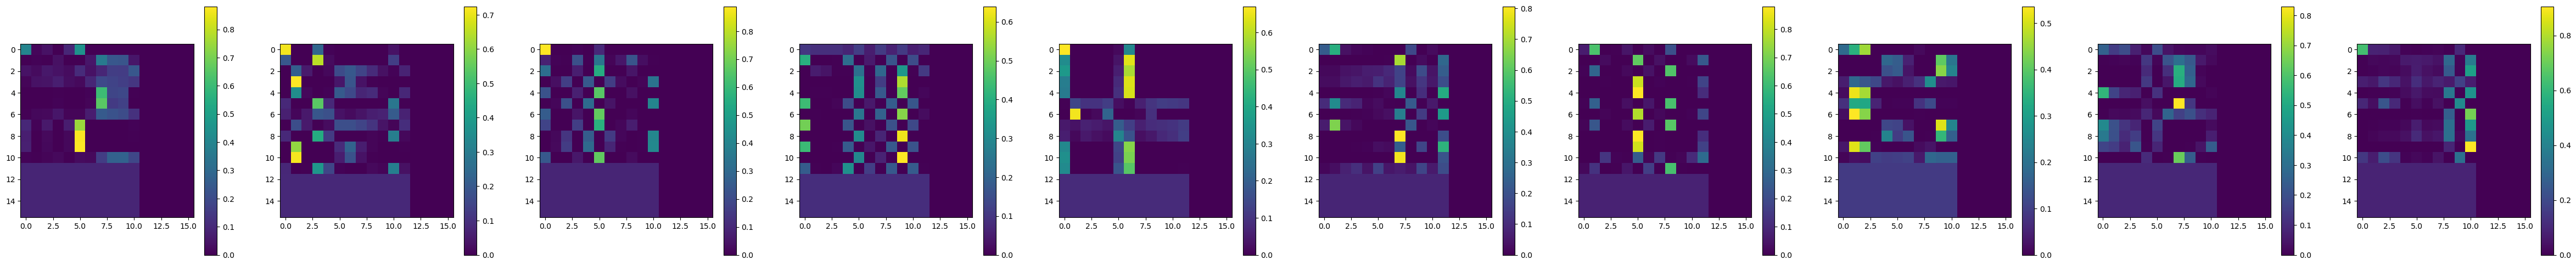

In [78]:
plotM(*coord_att_ws[0:10], t=False)

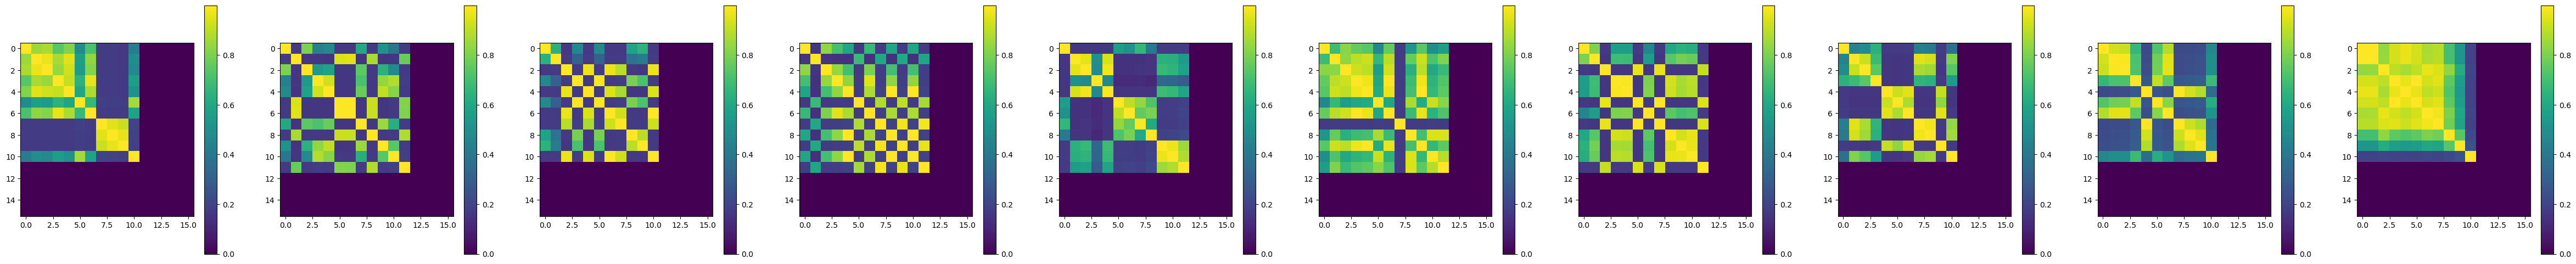

In [79]:
plotM(*adj[0:10])

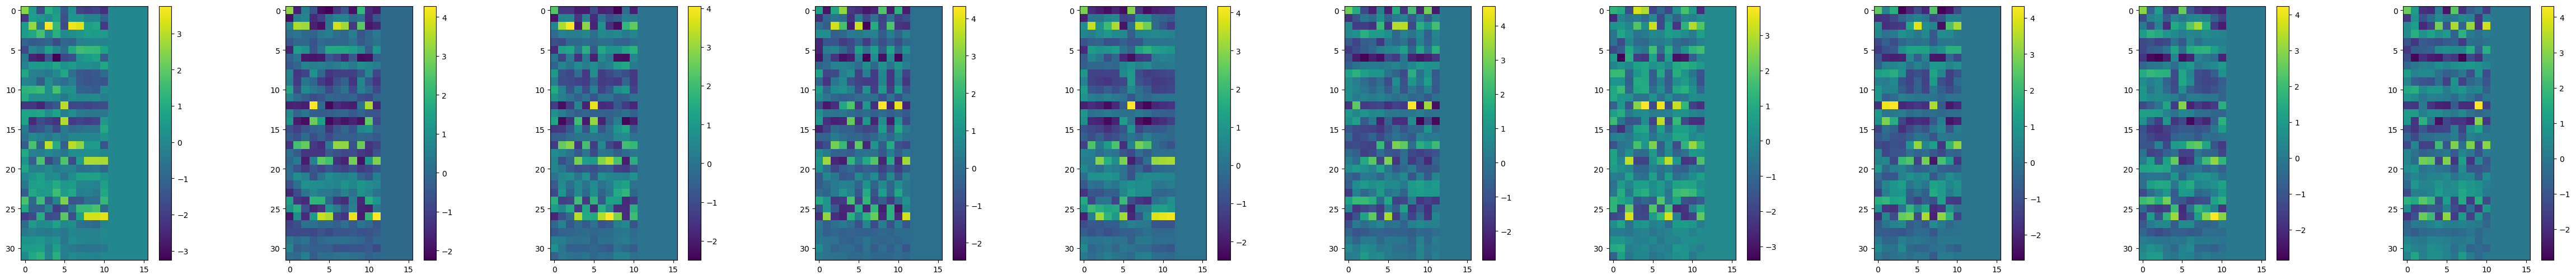

In [80]:
plotM(*cl_X[0:10])

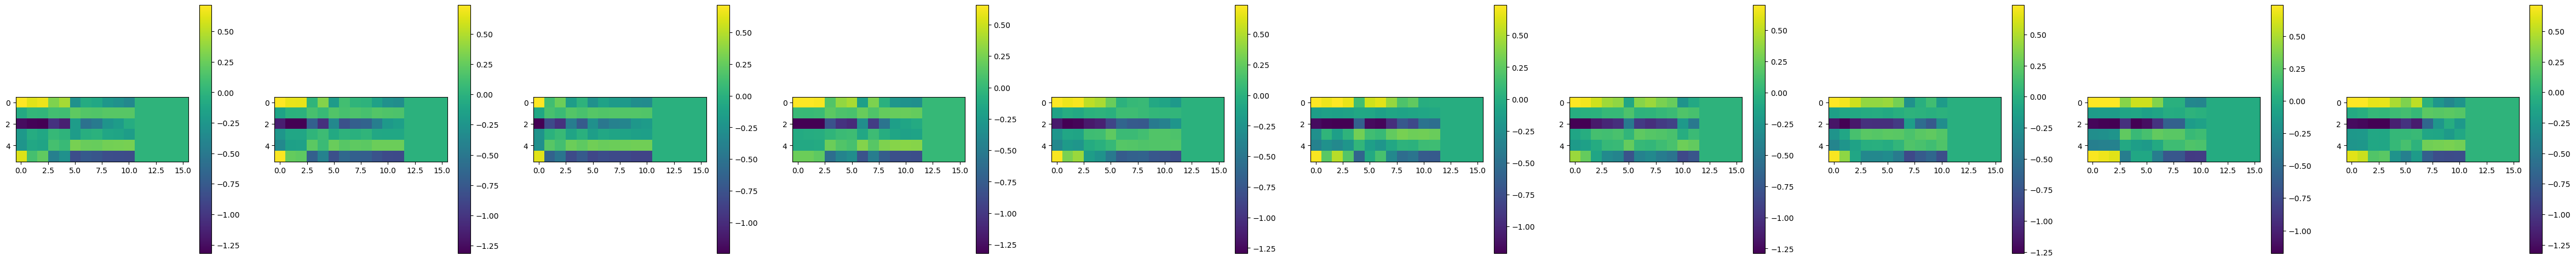

In [81]:
plotM(*output_rechits[0:10])

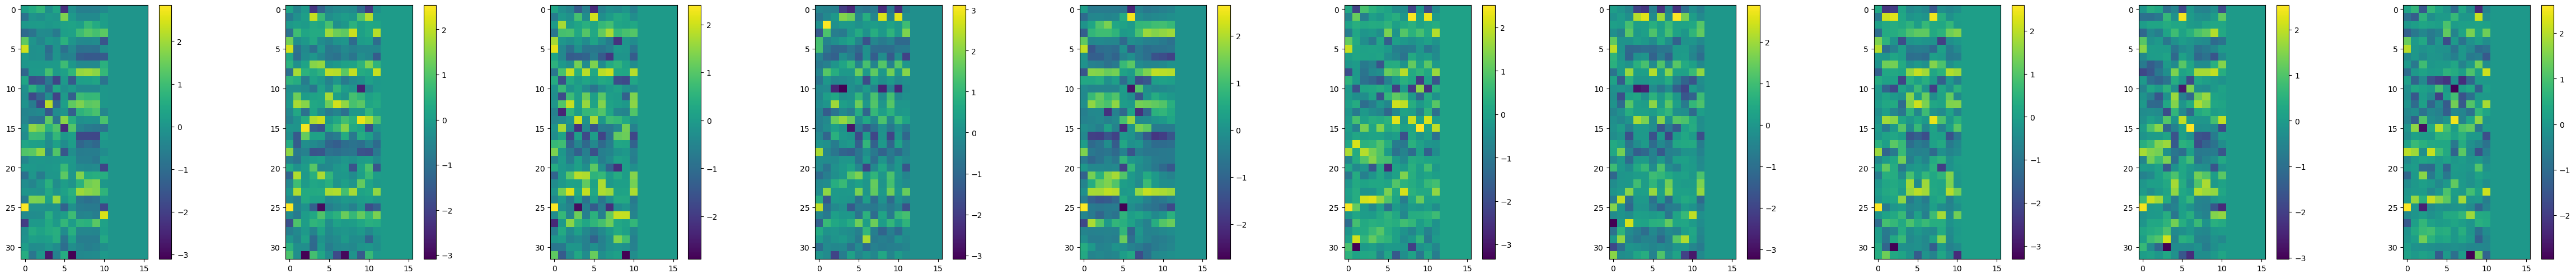

In [82]:
plotM(*out_gcn[0:10])

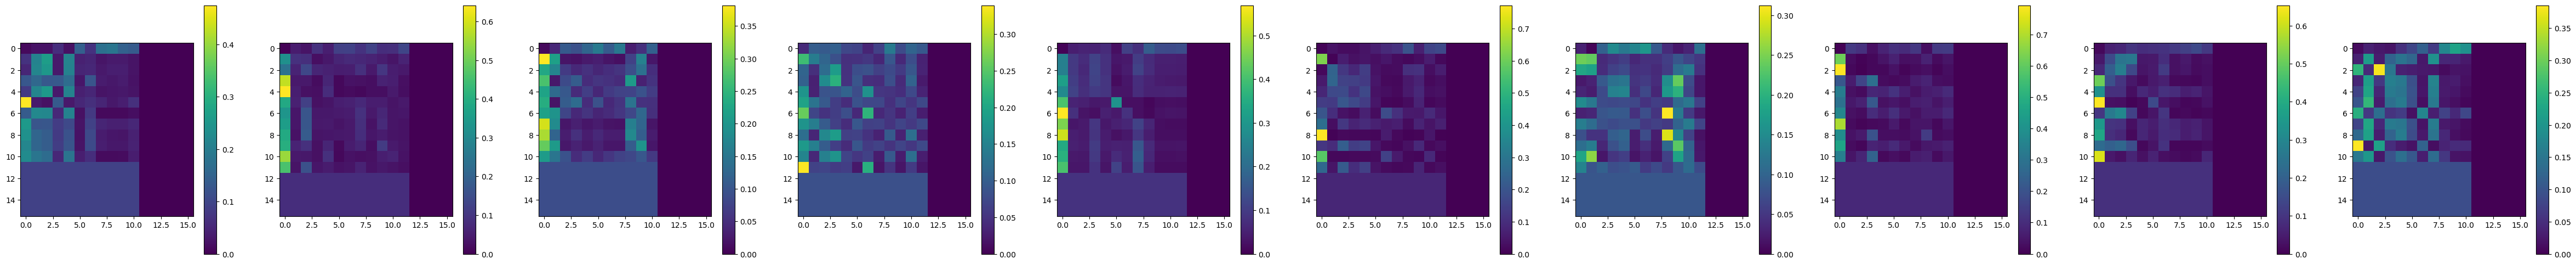

In [83]:
plotM(*att_weights_clcall[0:10], t=False)

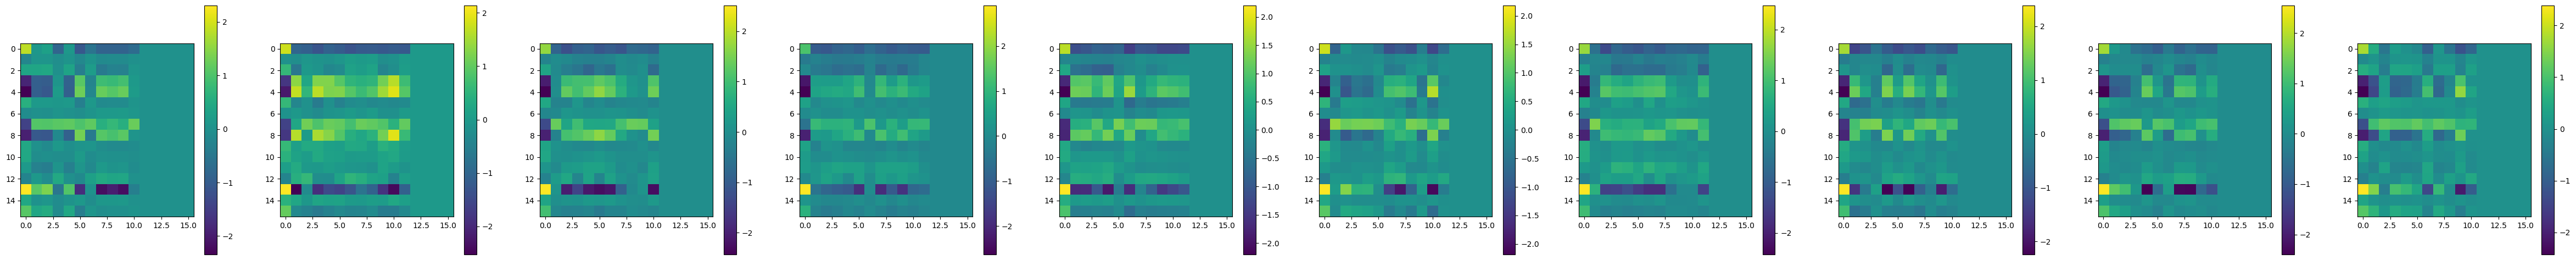

In [84]:
plotM(*out_SAcl[0:10])

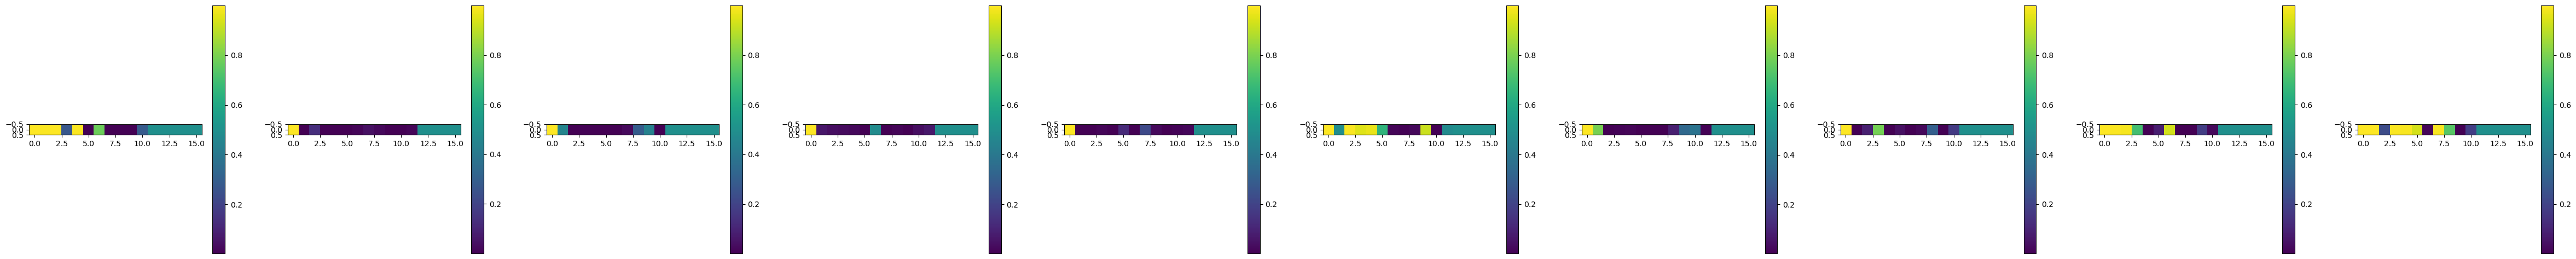

In [85]:
plotM(*tf.nn.sigmoid(dense_clclass)[0:10])

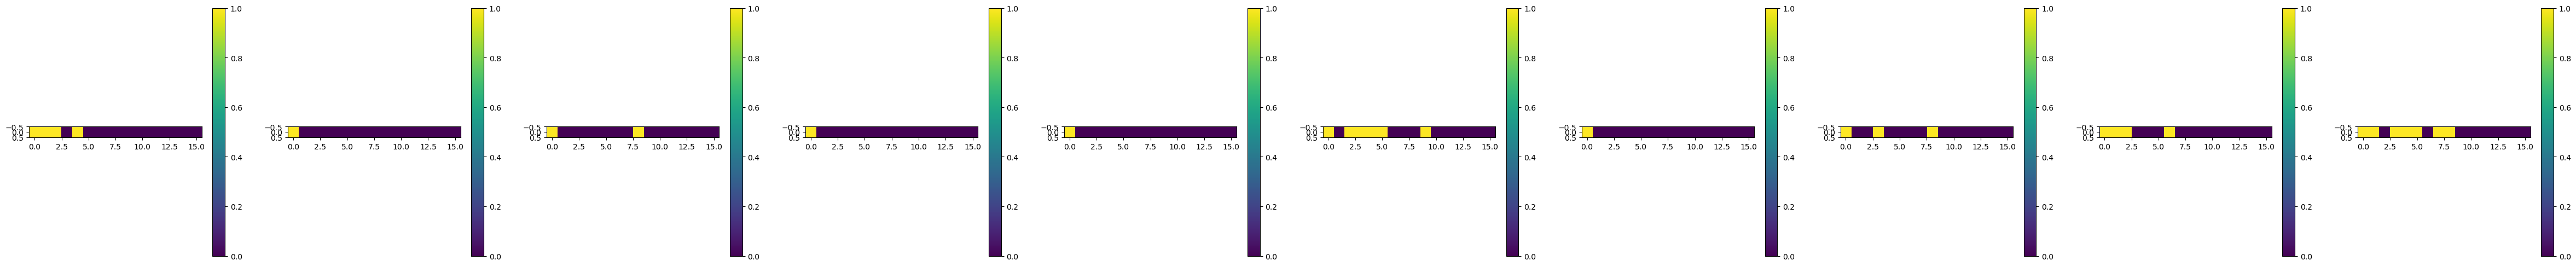

In [86]:
plotM(*y[0][0:10])

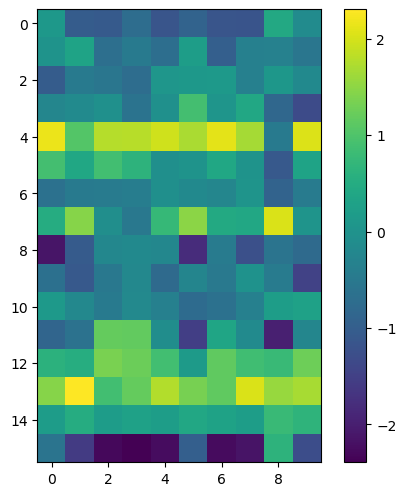

In [71]:
plotM(out_SAw[0:10])

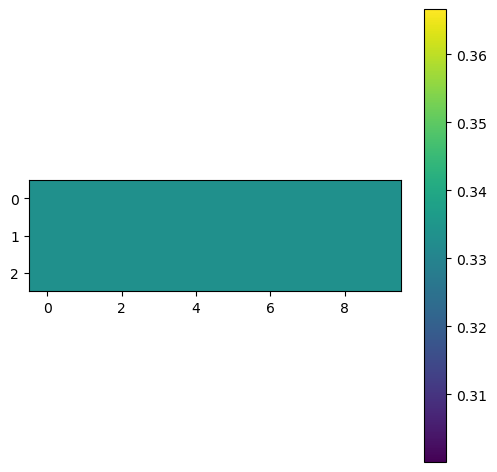

In [72]:
plotM(tf.nn.softmax(windclass[0:10]))

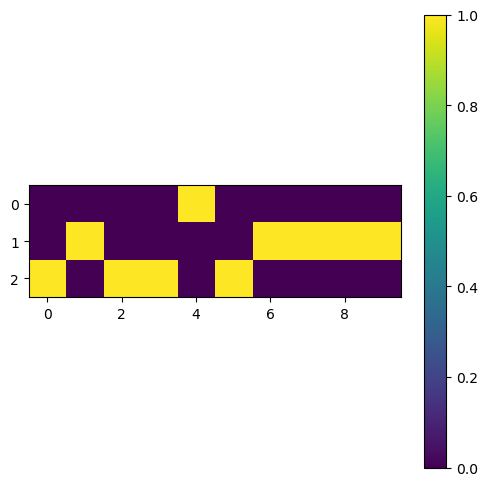

In [73]:
plotM(y[1][0:10])

# Test training

In [16]:
from model import *
from plotting import * 

In [11]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v3/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','coord_dim','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','n_windclasses',
                          'dropout','l2_reg'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 0,
nepochs = 10,
ntrain = 300000,
nval = 50000,
lr_decay = 0,
lr = 1e-3,
batch_size = 128,
opt='nadam',
    
activation = tf.keras.activations.selu,
output_dim_rechits = 6,
output_dim_nodes = 32,
output_dim_gconv = 32,
output_dim_sa_clclass = 16,
output_dim_sa_windclass = 16,
coord_dim = 3,
nconv_rechits = 3,
nconv = 3,
layers_input = [32,32],
layers_clclass = [32,32],
layers_windclass = [32, 32],
n_windclasses = 3, 
dropout = 0.1,
l2_reg = True, 
)

### Dataset loading

In [7]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v3/run_18


In [8]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v6/training/calo_matched/*.proto",
                  "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v6/testing/calo_matched/*.proto",
                   "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [9]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]


metadata =  [  "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
            "nclusters_insc","max_en_cluster_insc","max_deta_cluster_insc",
            "max_dphi_cluster_insc",
             "max_en_cluster","max_deta_cluster","max_dphi_cluster",
            "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ]

In [58]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features, metadata,  args.batch_size,weights={"ele_match":0.45,"gamma_match":0.45, "nomatch":0.1} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.normalize_features(train_ds, "normalization.npz")
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, metadata, args.batch_size,weights={"ele_match":0.45,"gamma_match":0.45, "nomatch":0.1})
# the indexes for energy and et are from the features list we requestes
test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.normalize_features(test_ds, "normalization.npz")
test_ds = tf_data.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(200).take(args.ntrain // args.batch_size).repeat(args.nepochs)
ds_test  = test_ds.prefetch(200).take(args.nval // args.batch_size).repeat(args.nepochs)

In [74]:
def filter(d1,d2):
    return d1["n_cl"] > 10 and d1["s_f"][0] > 1.5 and d1["s_f"][0] < 2

special_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, metadata,  args.batch_size,filter=filter, weights={"ele_match":0.45,"gamma_match":0.45, "nomatch":0.1})
# the indexes for energy and et are from the features list we requestes
special_ds = tf_data.delta_energy_seed(special_ds, en_index=0, et_index=1)
special_ds = tf_data.normalize_features(special_ds, "normalization.npz")
special_ds = tf_data.training_format(special_ds)

In [13]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [17]:
def get_model(args, weights=None):

    loss_weights = {"clusters":1., "window":0., "etw":1., "et_miss":5, "et_spur":1.5}

    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        # Construction of the model
        model = DeepClusterGN(
                    activation = args.activation,
                    output_dim_rechits = args.output_dim_rechits,
                    output_dim_nodes =args.output_dim_nodes,
                    output_dim_gconv = args.output_dim_gconv,
                    output_dim_sa_clclass = args.output_dim_sa_clclass,
                    output_dim_sa_windclass = args.output_dim_sa_windclass,
                    coord_dim = args.coord_dim,
                    nconv_rechits = args.nconv_rechits,
                    nconv = args.nconv,
                    layers_input = args.layers_input,
                    layers_clclass = args.layers_clclass,
                    layers_windclass = args.layers_windclass,
                    n_windclasses = args.n_windclasses,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg,
                    loss_weights= loss_weights
                    )


        model.compile(optimizer=args.opt)
    #         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
    #                      energy_resolution_insc_log,energy_resolution_outsc_log,])
        model.set_metrics()

        for X, y in ds_train:
            ypred = model(X)
            #l = custom_loss(y, ypred)
            break
        
        if weights:
            model.load_weights(weights)
        
        return model

In [18]:
model = get_model(args)

In [19]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)
callbacks += [cp_callback]



In [20]:
model.summary()

Model: "deep_cluster_gn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  3666      
_________________________________________________________________
GHN_global (GHConvI)         multiple                  2080      
_________________________________________________________________
SA_clclass (SelfAttention)   multiple                  2656      
_________________________________________________________________
dense_clclass (Sequential)   (128, 15, 1)              1633      
_________________________________________________________________
SA_windclass (SelfAttention) multiple                  2656      
_________________________________________________________________
dense_windclass (Sequential) (128, 3)                  1699      
_________________________________________________________________
dropout_37 (Dropout)         multiple            

In [21]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 1/10
2343/2343 [==============================] - ETA: 0s - loss: 2.0794 - loss_clusters: 0.8075 - loss_windows: 1.1094 - loss_etw: 0.0390 - loss_et_miss: 0.1935 - loss_et_spur: 0.0940
Epoch 00001: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v3/run_18/weights.01-1.197071.hdf5
2343/2343 [==============================] - 125s 53ms/step - loss: 2.0794 - loss_clusters: 0.8075 - loss_windows: 1.1094 - loss_etw: 0.0390 - loss_et_miss: 0.1935 - loss_et_spur: 0.0940 - val_loss: 1.1971 - val_loss_clusters: 0.5782 - val_loss_windows: 1.0986 - val_loss_etw: 0.0209 - val_loss_et_miss: 0.0874 - val_loss_et_spur: 0.0534
Epoch 2/10
2342/2343 [============================>.] - ETA: 0s - loss: 1.2201 - loss_clusters: 0.6121 - loss_windows: 1.0986 - loss_etw: 0.0223 - loss_et_miss: 0.0866 - loss_et_spur: 0.0634
Epoch 00002: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v3/run_18/weights

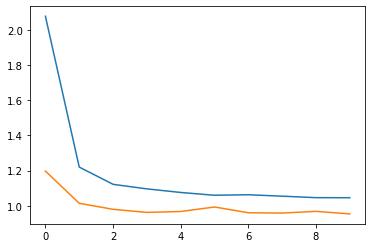

In [22]:
plt.plot(ret.history["loss"])
plt.plot(ret.history["val_loss"])
#plt.ylim(0.2,2) 

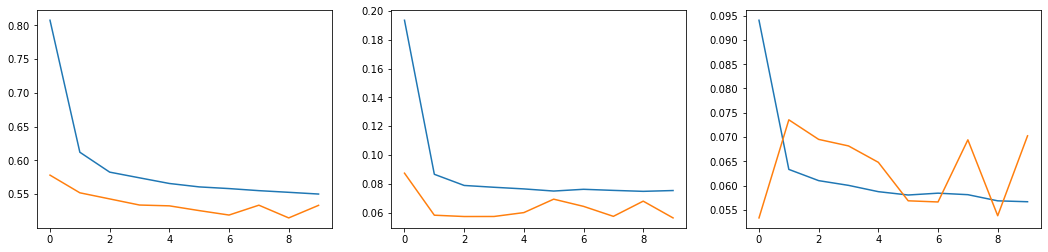

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.plot(ret.history["loss_clusters"])
ax1.plot(ret.history["val_loss_clusters"])

ax2.plot(ret.history["loss_et_miss"])
ax2.plot(ret.history["val_loss_et_miss"])

ax3.plot(ret.history["loss_et_spur"])
ax3.plot(ret.history["val_loss_et_spur"])

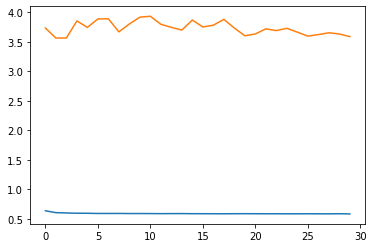

In [48]:
plt.plot(ret.history["loss_windows"])
plt.plot(ret.history["val_loss_windows"])
#plt.ylim(0.2,2) 

In [24]:
model.save(outdir + '/model')

### Test loss

In [41]:
X,y_true= tf_data.get(ds_test)

In [42]:
y_pred = model(X)

In [44]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true

selected_cls =  tf.cast(tf.nn.sigmoid(dense_clclass) > 0.5, tf.int64)
    
diff = y_clclass - selected_cls

In [71]:
missing_en = tf.squeeze(tf.where(diff==1, cl_X[:,:,0][:,:,tf.newaxis], tf.zeros(diff.shape)))

In [72]:
tf.reduce_sum(missing_en)

<tf.Tensor: shape=(), dtype=float32, numpy=7.107602>

In [65]:
spurious_en =  tf.squeeze(tf.where(diff==-1, cl_X[:,:,0][:,:,tf.newaxis], tf.zeros(diff.shape)))

In [70]:
tf.reduce_mean(missing_en)

<tf.Tensor: shape=(), dtype=float32, numpy=0.007932591>

In [30]:
model.layers

In [255]:
model.load_weights("/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v3/run_13/weights.04-22.334915.hdf5")

KeyError: "Unable to open object (object 'layer_normalization_124' doesn't exist)"

In [79]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
model.save(outdir+"/model")
    

## Check metadata

In [154]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]


metadata =  [  "obsPU"]

In [165]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v6/training/calo_matched/*.proto",
                  #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }


In [173]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds_ele = tf_data.load_dataset_single(data_path_train['ele_match'], options={'read_hits':False, 'read_metadata':True}).take(50000)
train_ds_gamma = tf_data.load_dataset_single(data_path_train['gamma_match'], options={'read_hits':False, 'read_metadata':True}).take(50000)
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
# train_ds = tf_data.training_format(train_ds)


In [158]:
import ROOT as R 

Welcome to JupyROOT 6.22/06


In [172]:
h_PU_ele = R.TH1F("hPUele","hPU", 50, 30,100)
h_PU_gamma = R.TH1F("hPUgamma","hPU", 50, 30,100)

Warning in <TROOT::Append>: Replacing existing TH1: hPUele (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hPUgamma (Potential memory leak).


In [160]:
mindex = tf_data.get_window_metadata_indexes(['obsPU'])

In [174]:
i = 0
for ev1, ev2 in zip(train_ds_ele, train_ds_gamma):
    if i%1000 ==0: print('.',end="")
    h_PU_ele.Fill(ev1[0]["w_m"][mindex[0]])
    h_PU_gamma.Fill(ev2[0]["w_m"][mindex[0]])
    i+=1

..................................................

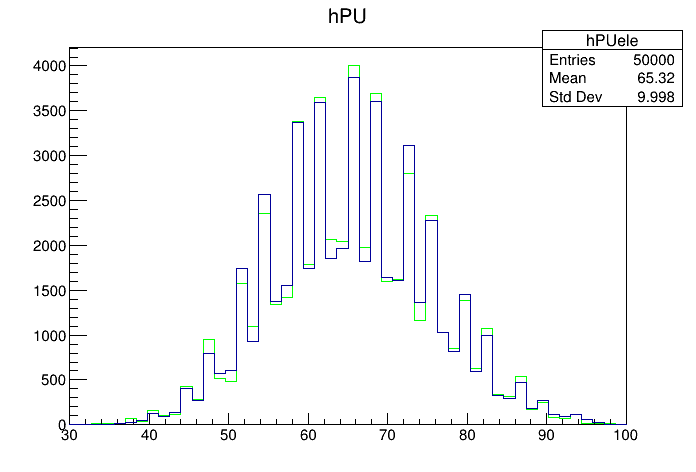

In [175]:
c = R.TCanvas()
h_PU_ele.Draw()
h_PU_ele.SetLineColor(R.kGreen)
h_PU_gamma.Draw("same")
c.Draw()

# Debug model



In [ ]:
#OLd model
